Install Julia if running on Google Colab

In [ ]:
%%capture
%%shell
wget -O - https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/docs/src/examples/colab.sh
"""
This should take around one minute to finish. Once it does, change the runtime to `Julia` by choosing `Runtime` 
from the toolbar then `Change runtime type`. You can then delete this cell.
"""

Install needed packages

In [ ]:
ENV["JULIA_PKG_SERVER"] = ""
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
Pkg.add(["DataFrames", "Plots", "Colors", "CategoricalArrays", "Random", 
         "Imbalance", "MLJBase", "TableTransforms", "ScientificTypes", "HTTP"])

using DataFrames
using Plots
using CategoricalArrays
using Random
using Imbalance
using MLJBase: machine, transform
using TableTransforms
using HTTP: download

### 1. Generate Random Data

In [109]:
rng = Random.default_rng()

type = "ColTable"
num_rows = 300
num_features = 2
class_probs = [0.5, 0.2, 0.3]
stds = [0.1 0.2 0.3]
y_ind = 3

Xy, _ = generate_imbalanced_data(
	num_rows,
	num_features;
	min_sep = 0.4,
	stds,
	class_probs,
	type,
	insert_y = y_ind,
	rng = 10,
)
X, y = generate_imbalanced_data(
	num_rows,
	num_features;
	min_sep = 0.4,
	stds,
	class_probs,
	type,
	rng = 10,
)

((Column1 = [-0.097, 0.443, 1.065, 0.618, 0.774, 0.764, 0.977, 0.778, 1.034, 0.532  …  1.161, 1.2, 0.511, 0.599, 0.443, 0.87, 0.822, 0.956, 0.593, 0.581], Column2 = [1.411, 1.643, 2.453, 0.656, 0.824, 0.782, 2.174, 0.754, 1.623, 1.407  …  2.254, 2.148, 0.734, 1.553, 1.926, 0.806, 2.053, 2.478, 1.387, 0.768]), CategoricalValue{Int64, UInt32}[2, 2, 1, 0, 0, 0, 1, 0, 2, 2  …  1, 1, 0, 2, 2, 0, 1, 1, 2, 0])

### 2. Apply BorderlineSMOTE1

#### Using Imbalance Only

In [110]:
Xover, yover = borderline_smote1(X, y; m=5, k=5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.0), rng = 42)

((Column1 = [-0.097, 0.443, 1.065, 0.618, 0.774, 0.764, 0.977, 0.778, 1.034, 0.532  …  0.9242215752601624, 0.844352662563324, 0.8548136949539185, 0.7572011947631836, 0.8308550715446472, 0.8985545039176941, 0.7272965312004089, 0.8034459352493286, 0.8135806322097778, 0.8442092537879944], Column2 = [1.411, 1.643, 2.453, 0.656, 0.824, 0.782, 2.174, 0.754, 1.623, 1.407  …  1.8788689374923706, 1.9203901290893555, 1.8817648887634277, 2.150198221206665, 2.007986545562744, 1.8754314184188843, 2.1950552463531494, 2.071430206298828, 2.0695483684539795, 1.9401030540466309]), CategoricalValue{Int64, UInt32}[2, 2, 1, 0, 0, 0, 1, 0, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Using MLJ

In [111]:
smote_model = Imbalance.MLJ.BorderlineSMOTE1(m = 5, k = 5, ratios = Dict(0=>1.2, 1=> 1.2, 2=>1.0), rng=42)
mach = machine(smote_model)
Xover, yover = transform(mach, X, y)

((Column1 = [-0.097, 0.443, 1.065, 0.618, 0.774, 0.764, 0.977, 0.778, 1.034, 0.532  …  0.9242215752601624, 0.844352662563324, 0.8548136949539185, 0.7572011947631836, 0.8308550715446472, 0.8985545039176941, 0.7272965312004089, 0.8034459352493286, 0.8135806322097778, 0.8442092537879944], Column2 = [1.411, 1.643, 2.453, 0.656, 0.824, 0.782, 2.174, 0.754, 1.623, 1.407  …  1.8788689374923706, 1.9203901290893555, 1.8817648887634277, 2.150198221206665, 2.007986545562744, 1.8754314184188843, 2.1950552463531494, 2.071430206298828, 2.0695483684539795, 1.9401030540466309]), CategoricalValue{Int64, UInt32}[2, 2, 1, 0, 0, 0, 1, 0, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Using TableTransforms

In [112]:
using Imbalance: TableTransforms.BorderlineSMOTE1
smote_model_t = BorderlineSMOTE1(y_ind, m=5, k=5, ratios=Dict(0=>1.2, 1=> 1.2, 2=>1.0), rng=42)
Xyover = Xy |> smote_model_t

(Column1 = [-0.097, 0.443, 1.065, 0.618, 0.774, 0.764, 0.977, 0.778, 1.034, 0.532  …  0.9242215752601624, 0.844352662563324, 0.8548136949539185, 0.7572011947631836, 0.8308550715446472, 0.8985545039176941, 0.7272965312004089, 0.8034459352493286, 0.8135806322097778, 0.8442092537879944],
 Column2 = [1.411, 1.643, 2.453, 0.656, 0.824, 0.782, 2.174, 0.754, 1.623, 1.407  …  1.8788689374923706, 1.9203901290893555, 1.8817648887634277, 2.150198221206665, 2.007986545562744, 1.8754314184188843, 2.1950552463531494, 2.071430206298828, 2.0695483684539795, 1.9401030540466309],
 Column3 = [2.0, 2.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 2.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],)

### 3. Plot the Results

   Resolving package versions...


  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Project.toml`
  No Changes to `~/Documents/GitHub/Imbalance.jl/examples/Manifest.toml`


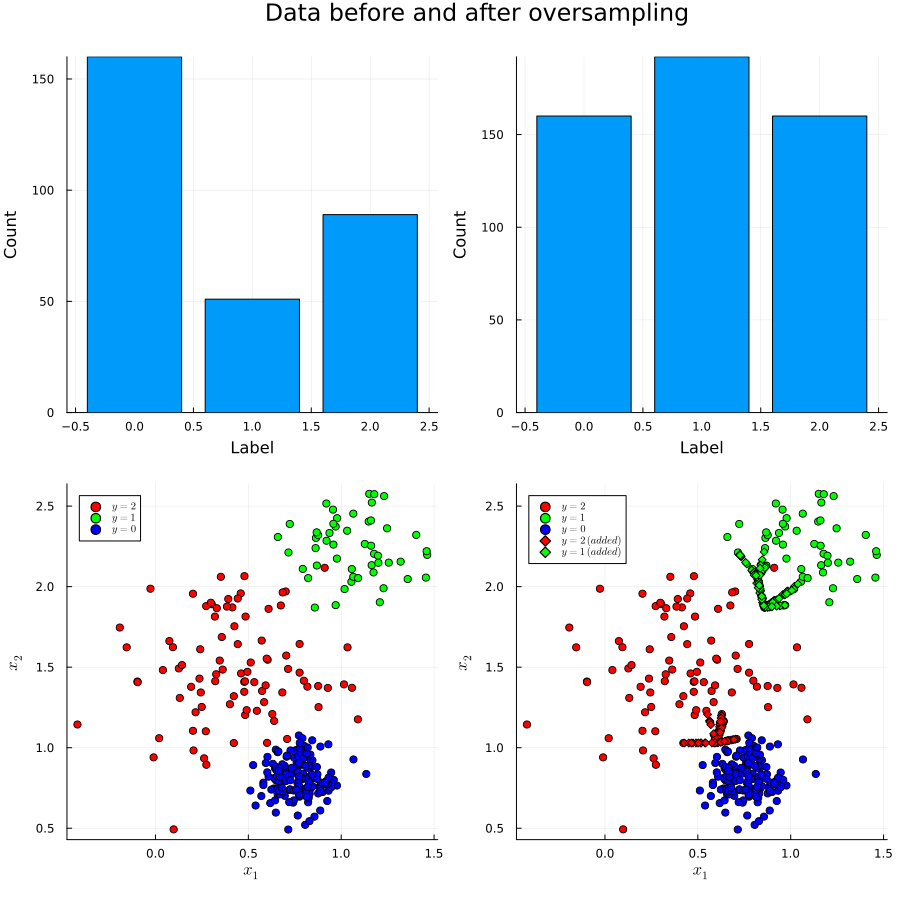

In [113]:
download("https://raw.githubusercontent.com/JuliaAI/Imbalance.jl/dev/examples/plot.jl", "./")
include("plot.jl")                      # provides a plot function to compare results
plot_data(y, yover, X, Xover)

Plots.AnimatedGif("/Users/essam/Documents/GitHub/Imbalance.jl/examples/assets/borderlinesmote1.gif")
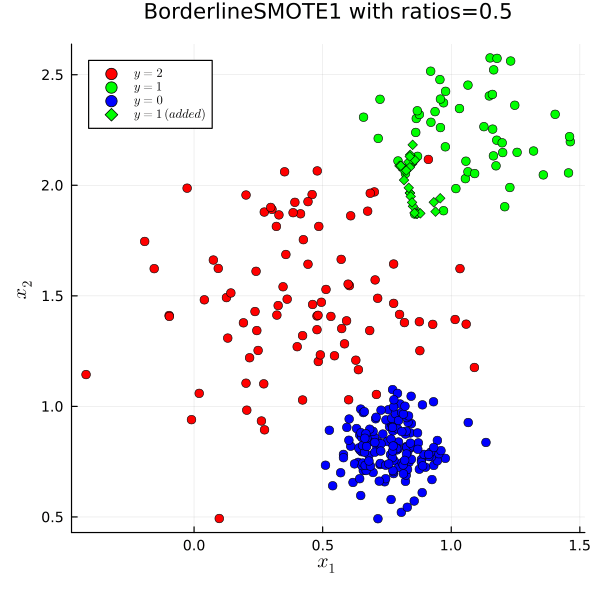

In [114]:
import Logging
Logging.disable_logging(Logging.Warn)

anim = @animate for ratios ∈ 0.5:0.01:1.2
	X_under, y_under = borderline_smote1(X, y; ratios = ratios, rng = Random.Xoshiro(42))
	plot_data(y, y_under, X, X_under; single_plot=true, 
			  single_plot_title="BorderlineSMOTE1 with ratios=$ratios")
end
gif(anim, (isdir("./assets")) ? "./assets/borderlinesmote1.gif" : "./borderlinesmote1.gif", fps=3)